In [34]:
# Non trivial dependencies

!pip install spacy
!pip install nltk
nltk.download('punkt')
!python -m spacy download en_core_web_sm
!pip install spacy_langdetect
!pip install pyLDAvis
!pip install yellowbrick
!pip install beautifulsoup4

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Suppress warning about chained assignments
pd.options.mode.chained_assignment = None

### Read dataset

In [2]:
# Code assumes dataset is in the same directory

data_path = 'Dummy_News_Sample.csv'
df = pd.read_csv(data_path)

In [3]:
# Cast doc_text column to string
df['doc_text'] = df['doc_text'].astype("string")

# Remove any NaN rows
df.dropna(subset=['doc_text'], inplace=True)

### Determine length of each document

Calculating the length on each document depends on a few different things, such as the tokenizer used and whether the preprocessing in done beforehand or not. Since we will be filtering based on some quartile, the relevant positions of lengths are more or less going to be same.

<AxesSubplot:>

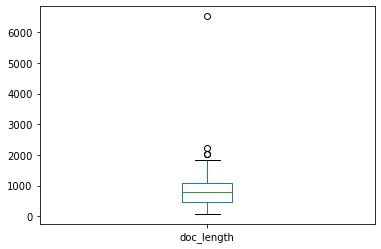

In [4]:
import nltk
from nltk import word_tokenize

df['doc_length'] = df['doc_text'].map(lambda text: len(word_tokenize(text)))
df['doc_length'].plot.box()

### Filter df based on document length

In [5]:
threshold = df['doc_length'].quantile(.75)

df_filtered = df[df['doc_length'] <= threshold]
print(f'Discarded {df.shape[0] - df_filtered.shape[0]} out of {df.shape[0]} rows')

Discarded 25 out of 100 rows


### Determine language and confidence score

In order to detect the language of the text I decided to use a simple corresponding module of Spacy. Other more advanced approaches would have been training (small) neural network models in monolingual/multilingual corpora, though this task is challenging only in the case of doduments containing multiple languages at the same time. In that case, a threshold of the model's confidence score should be considered before filtering out documents.

In [6]:
import spacy
from spacy.language import Language
from spacy_langdetect import LanguageDetector

nlp = spacy.load("en_core_web_sm")

@Language.factory("language_detector")
def create_language_detector(nlp, name):
    return LanguageDetector(language_detection_function=None)

nlp.add_pipe('language_detector')

In [7]:
# Text preprocessed by Spacy's linguistic pipeline that includes language detection and entity recognition (among others)
df_filtered['doc_text_spacy'] = df_filtered['doc_text'].map(lambda text: nlp(text))
df_filtered['language'] = df_filtered['doc_text_spacy'].map(lambda text: text._.language)

df_filtered['language_confidence'] = df_filtered['language'].map(lambda lang: lang['score'])
df_filtered['language'] = df_filtered['language'].map(lambda lang: lang['language'])

df_filtered['language_confidence'].describe()

count    75.000000
mean      0.999997
std       0.000001
min       0.999995
25%       0.999996
50%       0.999997
75%       0.999998
max       0.999999
Name: language_confidence, dtype: float64

It is noticed that the confidence of the language detector is exteremely high, leading to the conclusion that texts do not contain multiple languages and are easy to detect. Therefore, no threshold of confidence needs to be set before in filtering non-english text. The distribution of other, non-english languages detected is shown below.

[Text(0.5, 0, 'Language'), Text(0, 0.5, 'Number of documents')]

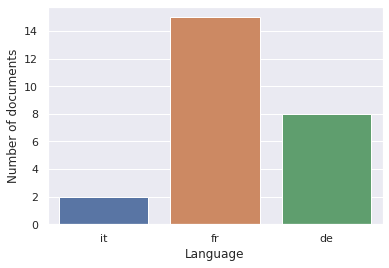

In [8]:
import seaborn as sns
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="language", data=df_filtered[df_filtered['language'] != 'en'])
ax.set(xlabel='Language', ylabel='Number of documents')

### Filter df based on language

In [9]:
df_filtered_lang = df_filtered[df_filtered['language'] == 'en']
print(f'Discarded {df_filtered.shape[0] - df_filtered_lang.shape[0]} out of {df_filtered.shape[0]} rows')

Discarded 25 out of 75 rows


### Entity recognition

Spacy's statistical NER performs decently and that's why it was selected. Training an NER from scratch requires customizing and fine-tunning but might be the best option in order to achieve more accurate results, especially when having large amount of data. Pre-trained transformer-based models can also be used, and HugginFace provides a BERT-based one that is also trained on news articles (https://huggingface.co/dslim/bert-base-NER). However, it should be noted that, since it is BERT-based, it uses a subword tokenizer (WordPiece, specifically) so subwords are occasionally assigned entities.

In [10]:
df_filtered_lang['persons'] = df_filtered_lang['doc_text_spacy'].map(lambda text: [ent.text for ent in text.ents if ent.label_ == 'PERSON'])
df_filtered_lang['organisations'] = df_filtered_lang['doc_text_spacy'].map(lambda text: [ent.text for ent in text.ents if ent.label_ == 'ORG'])

The 10 most common Person and Organisation entities are shown below.

/home/pavlos2094/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0, 0.5, 'Count')

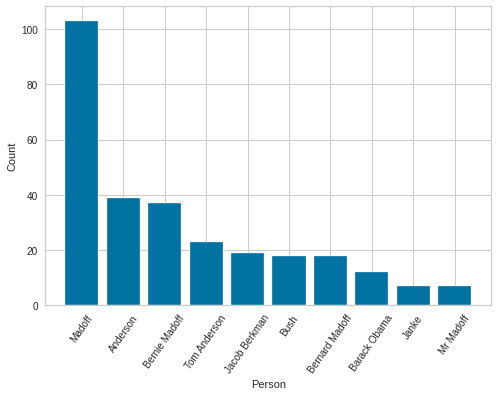

In [26]:
from collections import Counter
persons_counter = Counter([p for persons in df_filtered_lang['persons'] for p in persons])
# persons_counter.most_common(10)

persons_counter_dict = dict(persons_counter.most_common(10))
plt.bar(persons_counter_dict.keys(), persons_counter_dict.values())
plt.xticks(rotation=55)
plt.xlabel('Person')
plt.ylabel('Count')

The NER model has detected separate entities for Madoff (either with Mr. or his first name before), so grouping these together should be considered (part of the manual fine-tunning mentioned) for better results. Same applies for Anderson and Tom Anderson.

/home/pavlos2094/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0, 0.5, 'Count')

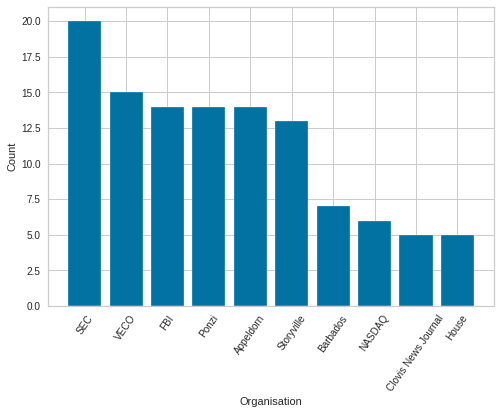

In [27]:
organisations_counter = Counter([o for organisations in df_filtered_lang['organisations'] for o in organisations])
# organisations_counter.most_common(10)

organisations_counter_dict = dict(organisations_counter.most_common(10))
plt.bar(organisations_counter_dict.keys(), organisations_counter_dict.values())
plt.xticks(rotation=55)
plt.xlabel('Organisation')
plt.ylabel('Count')

Wanting to make sure that VECO is actually an organisation and correctly caught by the NER of Spacy, I am going to sample a document that contains that and render it. It looks like the NER model was correct.

In [17]:
from spacy import displacy

doc = df_filtered_lang[df_filtered_lang['organisations'].map(lambda organisations: 'VECO' in organisations)]['doc_text_spacy'].sample()
displacy.render(doc, style="ent")

### Topic Μodelling

LDA creates 1) a document-topic model (trying to assign each document to as few topics possible) and 2) a topic-word model (trying to assign for each topic high probability to as few words as possible). The number of topics is a hyperparameter of the model chosen before training.

More advanced Topic Modelling approaches would include neural network models such as a Variational Auto-Encoder where the latent dimension of the intermediate layers would represent the different topics. Trying to encode and decode the document, the model would learn a low-dimensional representation that could be used to capture (non-linear) relations. That way, priors different from Dirichlet (such as Normal) could be considered instead to model the topic distribution. Testing new documents would also be simpler in that case, since with LDA this would require training the whole model from scratch with the updated dataset.

A similar approach to Topic Modelling, Document Clustering could also be leveraged. Steps would include representing the documents in some lower dimensional space (e.g. word embeddings or document embeddings such as doc2vec) and clustering using algorithms such as K-Means or even Hierarchical (Agglomerative) ones such as Ward.

In [19]:
from bs4 import BeautifulSoup

def preprocess(dataset):
    ds_preprocessed = []
    for doc in dataset:
        # Remove HTML that might have been mined from the news cluster
        tokenized = [BeautifulSoup(doc,'html').get_text()]
        '''
        Other preprocessing steps can be considered here, however, sklearn's CountVectorizer uses its own tokenizer and preprocessor
        that do useful things such as accent and stop word removal and lowercasing, which should be enough for our purpose.
        Lemamatization/stemming could also be used, though it didn't seem to have the best results in my case.
        '''  
        ds_preprocessed.append(' '.join(tokenized))
    
    return ds_preprocessed


corpus = preprocess(df_filtered_lang['doc_text'])

The following code cell creates a Bag of Words representation of the corpus that considers unigrams and bigrams (because some focal entities are bigrams), discards words that appear in more than 90% of the documents (since they would be too common to be meaningful to separate topics from) or in less than 3 documents (because they would appear so rarely that would provide a low singal to the model that would essentially be noise). Stop words are also removed.

In [20]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD

count_vectorizer = CountVectorizer(max_df=0.90, min_df=3, stop_words='english', ngram_range=(1, 2))
counts = count_vectorizer.fit_transform(corpus)

The top 20 words of the (preprocessed) corpus are illustrated below. Clearly, Person entities such as Madoff and Anderson as well as Organisation ones such as VECO play a pivotal role among our news, which are heavily influenced by business/financial articles.

/home/pavlos2094/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


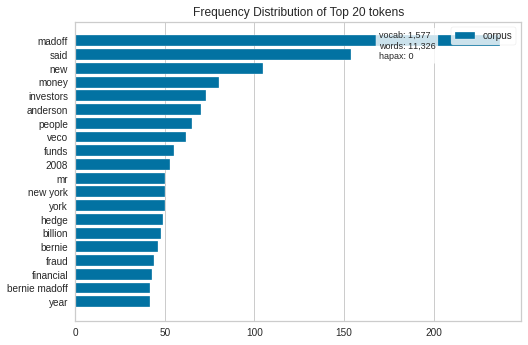

<AxesSubplot:title={'center':'Frequency Distribution of Top 20 tokens'}>

In [28]:
from yellowbrick.text import FreqDistVisualizer

visualizer = FreqDistVisualizer(features=count_vectorizer.get_feature_names(), orient='h', n=20)
visualizer.fit(counts).show()

The resulting LDA matrix contains the document-topic distribution with the corresponding probabilities. The dominant topic of each document can be considered the one with the highest probability.

In [22]:
n_topics = 6
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42).fit(counts)
lda_matrix = lda.transform(counts)

df_filtered_lang['dominant_topic'] = lda_matrix.argmax(axis=1)+1

The topics' created by the LDA model are presented along with the top 10 words and their corresponding weight. Essentially, these topics can be seen as clusters of words co-occuring with each other, with weighting.

In [23]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for idx, topic in enumerate(model.components_):
        topic_dict[f'topic_{idx+1}'] = [(feature_names[i], round(topic[i], 2)) for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

display_topics(lda, count_vectorizer.get_feature_names(), 10)

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6
0,"(funds, 37.17)","(president, 22.95)","(said, 24.77)","(said, 47.16)","(madoff, 165.75)","(veco, 59.72)"
1,"(hedge, 34.17)","(bush, 21.16)","(anderson, 20.69)","(new, 30.71)","(investors, 52.13)","(barbados, 31.58)"
2,"(madoff, 33.17)","(house, 13.63)","(court, 18.38)","(anderson, 26.75)","(money, 51.26)","(madoff, 24.98)"
3,"(said, 27.24)","(monday, 13.62)","(county, 18.16)","(city, 19.34)","(said, 44.21)","(anderson, 23.06)"
4,"(hedge funds, 25.17)","(america, 13.27)","(state, 16.72)","(body, 14.14)","(new, 39.29)","(jewish, 22.33)"
5,"(people, 21.17)","(barack obama, 11.17)","(case, 16.57)","(mr, 12.09)","(financial, 36.97)","(2008, 21.03)"
6,"(industry, 21.17)","(barack, 11.17)","(thursday, 16.04)","(anderson said, 10.62)","(mr, 36.16)","(december, 20.27)"
7,"(investors, 18.17)","(obama, 11.12)","(city, 16.0)","(council, 10.16)","(firm, 34.73)","(jacob, 18.9)"
8,"(fund, 15.17)","(people, 11.05)","(attorney, 14.93)","(police, 9.94)","(fraud, 34.02)","(berkman, 18.17)"
9,"(year, 12.17)","(tuesday, 10.88)","(myspace, 13.17)","(light, 9.81)","(scheme, 33.87)","(berkman december, 18.17)"


pyLDAvis is a great tool to interpret the topics in an LDA Topic Model. The LDA matrix is used to visualize document/topic percentages in a lower 2D representation using T-SNE on the left, while the topic (and corpus) term frequency is shown on the right.

In general, the hyperparameter value of 6 topics seems to be a good option, since topics are generously sized, well-separated from each other and, judging from their top words, easy to tell what they focus on. For example, Topic 1 seems to be talking about financial news deeply related to Mr. Madoff, while Topic 5 is a more politically related one, hence the existence of terms such as president, Bush, Obama and so on. Mr. Anderson is talked about on Topic 3 (more politically related news) and 6 (legal and law enforcement news), while VECO/Barbados (and possibly fraud/offshore news) are mentioned on Topic 4. Overall, many focal entities extracted on Step 3) heavily dominate each Topic generated by our LDA model.

In [24]:
import pyLDAvis
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda, counts, count_vectorizer, mds='tsne')

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
4       1.465019 -47.625065       1        1  31.617909
0      54.854797 -36.476795       2        1  18.455806
2      32.212929 -61.444572       3        1  14.587555
5       5.111096 -14.110332       4        1  13.649395
1      26.350170 -33.374702       5        1  11.720798
3      38.109818  -7.222781       6        1   9.968537, topic_info=              Term        Freq       Total Category  logprob  loglift
1498          veco   54.000000   54.000000  Default  30.0000  30.0000
1265          said  134.000000  134.000000  Default  29.0000  29.0000
96        anderson   59.000000   59.000000  Default  28.0000  28.0000
148       barbados   28.000000   28.000000  Default  27.0000  27.0000
894         madoff  217.000000  217.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
1452  tom anderson    6.336856   21.066444   Topic6  -5.1827   1.1044
1445          time    6.822316   32.648763   Topic6  -5.1089   0.7401
973        million    6.625009   30.703543   Topic6  -5.1383   0.7722
1096        people    6.746966   58.055902   Topic6  -5.1200   0.1534
284       children    4.989964   12.916252   Topic6  -5.4217   1.3547

[380 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
2         1  0.382272         10
2         3  0.445984         10
2         4  0.063712         10
2         6  0.127424         10
11        2  0.849157        156
...     ...       ...        ...
1570      6  0.398282  yesterday
1571      1  0.626205       york
1571      2  0.215933       york
1571      4  0.064780       york
1571      5  0.086373       york

[640 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 3, 6, 2, 4])

### Conclusion

It was an interesting task I had fun playing around with. The approaches that could have been considered are limitless (especially if provided with a richer dataset), but a few of them are outlined below:

- Language detection using more complex models. Necessary only if corpus contains multilingual documents.
- More fine-grained NER, with entities such as Political Person, Offshore Company etc.
- Graph analysis of Named Entities relatedness.
- Further preprocessing of the text before applying the LDA model, such as fuzzy deduplication.
- Other Topic Modelling algorithms/models such as LSA or VAEs.
- Exhaustive hyperparameter search on models (mostly number of topics, influenced by the number/coverage of focal entities) and optimise using perplexity/log likelihood.